# Appendix A: Photometric Errors

In doing photometry, you may have encountered situation what the errors actually mean. In this appendix, I will briefly explain the magnitude errors and its derivation.

## 1. Pixel-Wise Noise
CCD itself has two sources of errors which is everywhere on CCD pixels. They are the **Readout noise** and the **Poisson noise**. 

Readout noise is a Gaussian noise, denoted as $R$, and it *must* be given by the CCD manufacturer in *electron unit*. It is caused since a CCD is not perfect when counting the electrons inside the potential well. So even if we have 10 electrons, the CCD may give us that it got 7, 13, 9, ... electrons from time to time. The readout noise is the standard deviation of such imperfect counting from the CCD.

The Poisson noise occurs because what we get is the electron count. Due to the photon input, CCD pixel generates photoelectrons. This process is a Poissonian process, and thus it has inevitable Poisson noise. If the electron count is $N$, the Poisson noise, i.e., the standard deviation, is $\sqrt{N}$. Note that this $N$ is in electron unit, not in ADU, *so you must multiply the effective gain factor to the ADU counts to make it electron unit*.

These two noises are combined by error propagation (ignoring covariance as they are independent) as $\sqrt{N + R^2} = \sqrt{gN_{\rm ADU} + R^2}$ in electrons. $g$ means the effective gain and the subscript ADU means the unit of it is in ADU. Keep in mind that this error should **always** be considered for **every** pixel.

-----


## 2. Sky Value Estimation

We take an aperture to sum the total pixel values within the aperture and set an annulus to estimate the sky. But how do we estimate the best sky value and its uncertainty? 

### Mathematical Conclusion

First, in mathematical sense, the conclusion is that the true mean value of sky has expectation value of the sample mean of the sky pixels, and the uncertainty of it is calculated by Student-t distribution. In mathematical term, it is written as 

\begin{align}
	\frac{m_s - \mu_s}{s_s/\sqrt{n_s}} &\sim T_{n_s-1} \\
    \mu_s &= m_s \pm t^{\alpha}_{n_s-1} \frac{s_s}{\sqrt{n_s}}
\end{align}

$m_s$ and $\mu_s$ are the sample mean and true mean of sky, $s_s$ is the sample standard deviation of sky, $n_s$ is the number of sky pixels used for calculating $m_s$ and $s_s$, and $t^{\alpha}_{n_s-1}$ is the $t$ value above which the cdf of T-distribution with dof $n_s-1$ is $\alpha$. The $t$-value table is calculable by softwares, and some critical values are given at many web sites such as [here](http://math.tutorvista.com/statistics/t-distribution-table.html). If $n_s \rightarrow \infty$ (practically if larger than roughly about 30), the t-distribution is well approximated by Gaussian (normal) distribution.

### Astronomers' Language

But astronomers, especially if we are not interested in very accurate measurement, we only want to use simpler and informal formalism. In the following, I will explain the astronomers' language by introducing some mathematical theorems to justify it.

Consider you set an annulus with inner and outer radius of 10 and 20 pixels. Then there may be hundreds of pixels within the annulus, and they will be sigma clipped so that unwanted sources, bad pixels, etc, will be rejected. Say we are left with $n_s$ pixels. 

The frequency plot (histogram) of sky values will be somewhat irregular in its shape some times. But in mathematical sense, we have a good theorem called the **central limit theorem (CLT)**:

> Say [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) random variable $X \sim G(\mu, \sigma)$ ($X$ follows an unknown general probability distribution with true mean $\mu$ and true stdev $\sigma$). If we draw $n (\gg 1)$ samples, the sample mean will represent the true mean. More rigorously, the sample mean ($\bar{X}$) will approximately follow a Gaussian distribution:   
\begin{equation}
	\bar{X} \dot{\sim} \mathcal{N}(\mu, ( \sigma/\sqrt{n})^2)
\end{equation}

In our sky estimation, this means that if we take the sample mean of the pixel values from the sky annulus ($m_s$), it will be similar to the true sky mean ($\mu_s$), with uncertainty of true sky stdev divided by the sqrt of sky pixels ($\sigma_s/\sqrt{n_s}$):

\begin{equation}
	\mu_s \approx m_s \pm \frac{\sigma_s}{\sqrt{n_s}}
\end{equation}

This is true only when we have many sky pixels ($n_s \gg 1$). But how do we know the *true* sky stdev? We have another useful theorem which says we can assume $\sigma_s \approx s_s$, where $s_s$ is the *sample* sky stdev:

> For the same situation as CLT, the sample stdev ($ s^2 := \sum_i (X_i - \bar{X})^2 / (n-1) $) and the true stdev has following property:
\begin{equation}
	\frac{(n-1) s^2}{\sigma^2} \sim \chi^2_{n-1}
\end{equation}
In other words, $(n-1) s^2/\sigma^2$ follows a chi-square distribution with dof $(n-1)$. From the definition of chi-square distribution, one can calculate that the expected value of $s$ is $\sigma$. 

So we have

\begin{equation}
	\mu_s \approx m_s \pm \frac{s_s}{\sqrt{n_s}}
\end{equation}

It resembles the mathematical conclusion! This is when the t-value is 1, i.e., 1-sigma uncertainty.



### Why Mean?

Although all the logic we constructed above is based on rigorous mathematical theorems, mean is not always a good choice in practice. For example, the sigma-clipping with respect to the mean may cause severe problem if we have a few cosmic-rays (why?), since cosmic rays are un-wanted external interference, which is not from the "sky". In general, therefore, the sigma-clipping itself is done around median value, and thus the sky estimation is closely related to the median as well as to the mean.

Also, median or mean value *should* always be higher than the real sky value. This is because stellar flux from nearby regions should contaminate the sky pixels toward positive values, although they may be negligible if the field is not crowded by stars. These modicum amount of addition cannot be rejected by sigma-clipping technique, so mathematically mean or median value must be higher than the true sky. Therefore, the mode is better than median or mean to estimate the sky value in practice.

So [SExtractor](http://www.astromatic.net/software/sextractor) uses its own background estimation method, and more accurate description is given in [photutils document](https://photutils.readthedocs.io/en/stable/photutils/background.html#d-background-and-noise-estimation). SExtractor uses `(2.5 * median) - (1.5 * mean)`, which is an estimator of mode, not just `mean`, as the $m_s$. Only when `(mean - median) / std > 0.3` the `median` is used. IDL uses so-called MMM method, and IRAF has its own method, which are similar to SExtractor but only some of the coefficients are different. Note that these are empirical estimator of the *mode*, not the mean or median (but a function of these two to estimate the mode).

I haven't yet read/find rigorous reasoning for these, but SExtractor User's Manual says *mode is more stable than mean* when we are looking at a crowded ("many-star") region. This is intuitively reasonable, because the mean may be affected by stellar flux even after sigma clipping, when there are too many nearby stars in the annulus. The mode, however, is a bit noisier (uncertain) than mean, which also makes sense thinking about the nearby stars' flux contaminating annulus, so it is better to use mean when we have only few stars in the image. 


### Summary

Although we need to use the Student-t distribution to be rigorous, astronomers are satisfied with only the 1-sigma range, i.e., 

\begin{equation}
	\mu_s \approx m_s \pm \frac{s_s}{\sqrt{n_s}}~.
\end{equation}

This will suffice many of the astronomers without the explanation of t-distribution. This is because we have sky pixels of hundreds, and the t-distribution will be approximately Gaussian, so the uncertainty term in the equation can be roughly understood as the stdev of Gaussian distribution. 

Depending on softwares, different mode or mean estimation methods are used to infer $\mu_s$. Mode estimation is especially useful for crowded field photometry, and mean estimation is useful for non-crowded field since it's better in mathematical sense.


-----

## 3. Stellar Flux Estimation

In aperture photometry, we estimate the stellar flux as `sum - n_a * m_s`, i.e., the sum of all pixel values in the aperture, and subtract the sky counts per pixel times the number of pixels in aperture ($n_a$). The `sum` is easy to calculate, `n_a` is what we can change, and `m_s` is obtained from previous section. Then what is the uncertainty of this stellar flux?

Now let me say $ m_s $, $ s_s $, and $ \sigma_s $ are **all in the unit of electrons/pixel**. We further assume our $m_s$ is a constant within the aperture. Then the stellar flux in electron unit is

\begin{equation}
	N = \sum_{j=1}^{n_a} I_j - n_a m_s ~,
\end{equation}

where $ I_j $ is the pixel count in electrons of the $ j $-th pixel. The error propagation can be used as a rough error estimation:

\begin{equation}
	[\Delta N]^2= \left [ \Delta \left ( \sum_{j=1}^{n_a} I_j \right ) \right ]^2 + \left [ \Delta (n_a m_s)\right ]^2
			=  \sum_{j=1}^{n_a} [\Delta I_j]^2 + n_a^2 \left [ \Delta m_s \right ]^2 ~.
\end{equation}

Here, $ \Delta m_s $ means the true sky uncertainty: $\sigma_s \approx s_s/\sqrt{n_s} $, so the second term becomes $ n_a^2 s_s^2/n_s $. 

On the other hand, $ I_j $ must have *at least* the two pixel-wise error terms: the readout noise and Poisson noise. The readout noise exists as a constant over all pixels and is a Gaussian noise: We can sum them as $ n_a R^2 $. The Poisson noise term is nothing but square root of each pixel values, $ \sqrt{I_j} = \sqrt{N_j + m_s}$, and then it will be squared. Here, $N_j$ is the estimated pixel value solely due to the source at the $ j $-th pixel. Thus,

\begin{align}
	\sum_{j=1}^{n_a} [\Delta I_j]^2 &= n_a R^2 + \sum_{j=1}^{n_a} (N_j + m_s) \\
		&= n_a R^2 + N + n_a m_s\\
		&= N + n_a (m_s + R^2)
\end{align}

The second term $ n_a (m_s + R^2)$ is sometimes abbreviated as "`stdev`" especially in IRAF, which veils the actual meaning of it. 

The instrumental magnitude of the source is nothing but $ -2.5 \log_{10} N $, and the magnitude error is $ -(2.5/\log_e 10) \Delta N  $, with

\begin{align}
	N &= \sum_{j=1}^{n_a} I_j - n_a m_s ~,\\
	\Delta N &= \sqrt{ N + n_a (m_s + R^2) + \frac{n_a^2 s_s^2}{n_s}} ~.
\end{align}

Note that I said $ m_s $, $ s_s $, $ R $, and $ N $ are all in electrons unit. If some of these are in ADU unit, you must use the effective gain factor to make units consistent. That is why you sometimes encounter some terms like $ N/g $ in IRAF/AstroPy documentations.




* **Question**: Think about the meaning of each term in $\Delta N$. What will happen when you observe faint source? What happens if the sky is too bright? What about if the readout noise is large? What happens if we estimated the sky with only 10 pixels, or if the sample standard deviation of sky pixels is very high?


-----

## 4. Example

Say we are analyzing an image taken at a night from a telescope having readout noise $R$ 2 electrons per readout and gain $g$ is 2.2 electrons per ADU. 

The image contains only two detectable stars. The sky is estimated from the annuli at each star with inner/outer radius = 10/20 pixels, so say we have ~1,000 sky pixels used for the sky estimation after sigma clipping. Without considering the sky estimation process issue seriously, let me assume the sky has $n_s=1000$ as constant and $m_s = 30$ ADU per pixel with $s_s = 5$ ADU from each annulus. 

The stars are: A bright star with $N \sim 150$ ADU (S/N > 10) and a faint star with $N \sim 60$ ADU (S/N < 10), at the central pixel. Say their centroid positions are at (30, 30) and (70, 70), i.e., they are far-seperated.


Now we want to calculate the signal to noise ratio, i.e., $N/\Delta N$ (Here, signal is the total count $N$! $N$ is not for "noise" in this case.) **with respect to the aperture size**. How do you expect the stellar magnitude and its uncertainty?

To investigate this problem, let me generate a fake sky with Gaussian (which is oversimplification but useful for educational demonstration) and two fake stars. The psf I will use is the Moffat function with FWHM around 3 pixels.

Moffat psf FWHM = 3.392 pixels


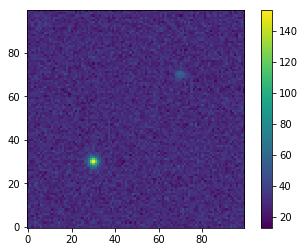

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.functional_models import Moffat2D

def FWHM_moffat(width, power):
    return 2*width * np.sqrt( 2**(1/power) - 1)

# from problem statement:
peak1 = 120  # so that peak + sky ~ 150
peak2 = 30   # so that peak + sky ~ 60
ronoise = 5
gain  = 2.2
pos1  = (30,30) # assume positions of stars are exactly known.
pos2  = (70,70)
m_s   = 30      # I will not make annuli to estimate the sky,
s_s   = 5       # but will use these m_s, s_s, and n_s as
n_s   = 1000    # as constant values.

# I will use the following psf:
width = 3
power = 2.5
MFWHM = FWHM_moffat(width, power)
print('Moffat psf FWHM = {0:.3f} pixels'.format(MFWHM)) # FWHM ~ 3.4 pixels

# Generate Moffat stars, Gaussian sky, and show:
y, x  = np.mgrid[:100, :100] # 2-D plane with 100x100 size
image = 0. * x + 0. *y
sky   = np.random.normal(loc=m_s, scale=s_s, size=image.shape) # mu and sigma
image+= sky
image+= Moffat2D.evaluate(x, y, peak1, *pos1, width, power)
image+= Moffat2D.evaluate(x, y, peak2, *pos2, width, power)
plt.imshow(image, origin='lower')
plt.colorbar()
plt.show()


If you prefer, you can save the fake image as FITS:

``` python
from ccdproc import CCDData

imagefits = CCDData(data=image, unit='adu')
imagefits.write('fake.fits')
```

and open it with ds9 or ginga to analyze it interactively:



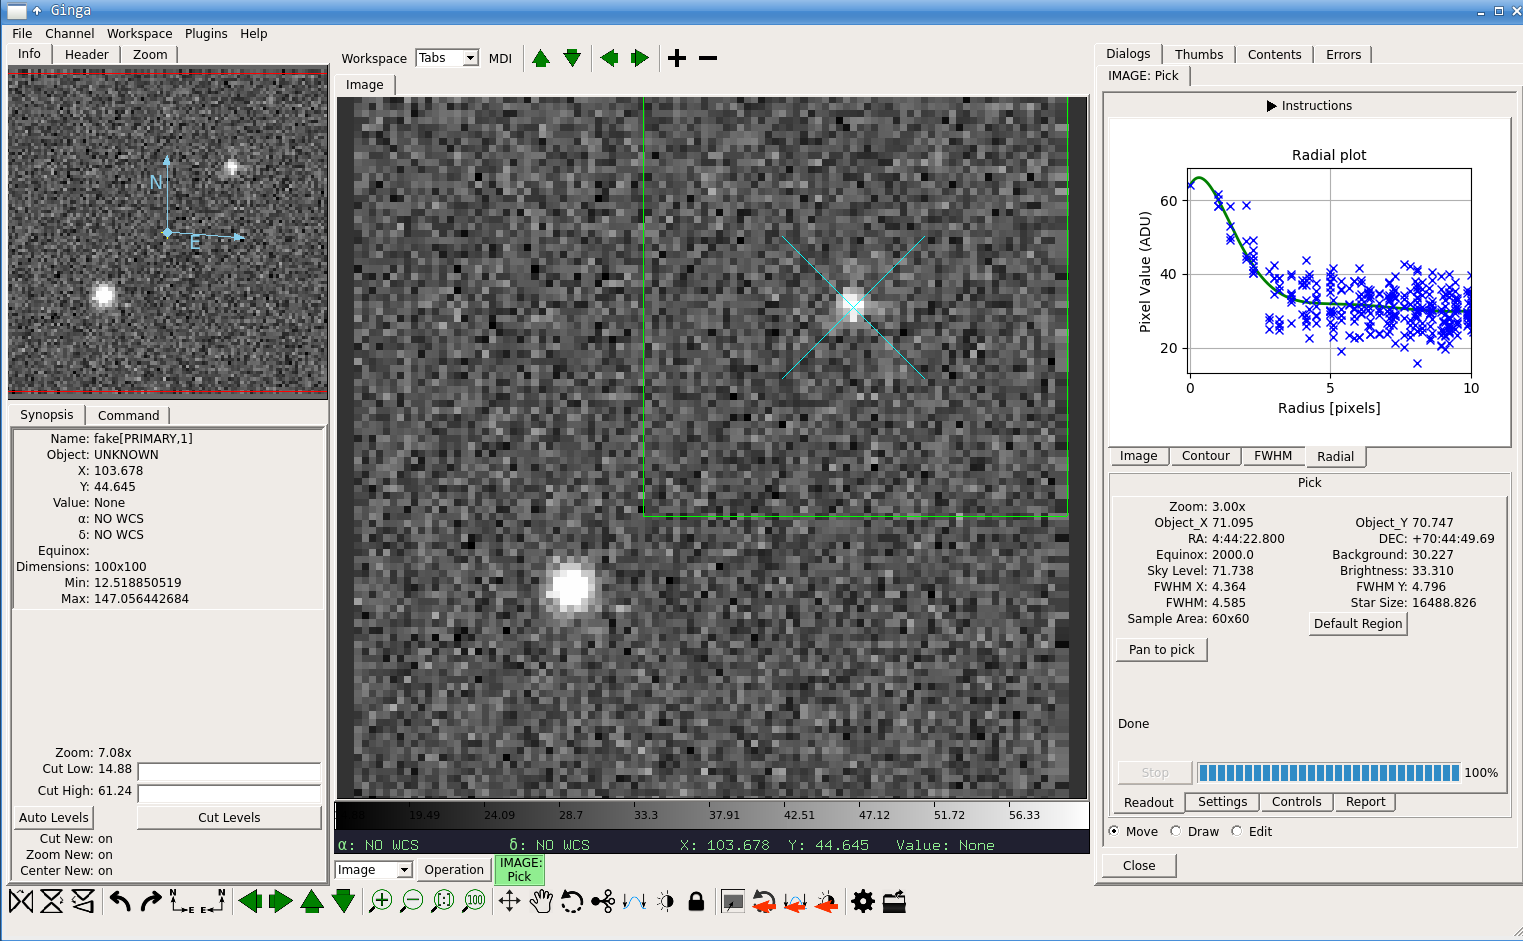

In [14]:
from IPython.display import Image
Image(filename='images/App_A_ginga.png', width=1000)

* **TIP**: In the above image, the FWHM in the bottom right panel is *before background subtraction*. If you click on the "`FWHM`" tab on the top right panel, what you see is the FWHM of *after background subtraction*.

As a second step, I want to do:

1. Generate the pixel-wise error map in ADU unit
  
  * You can do everything using electron unit from the beginning. You may use `astropy.units`. I just multiplied to the final flux (`aperture_sum`, which would be in ADU) for calculating the instrumental magnitude.   
  
2. generate many apertures (sizes from 1 to 10 pixels) using "`CircularAperture`", and then do the photometry (summation) using ["`aperture_photometry`"](https://photutils.readthedocs.io/en/stable/api/photutils.aperture_photometry.html#photutils.aperture_photometry).
  
  * The function `aperture_photometry` can take an option `error`. If you provide the error map to this, then the function automatically does the error propagation within the aperture. 
  * There is another option `pixelwise_error`, which can be either `True` or `False`. If it is true, then the function does the error propagation as usual. If it is false, the function ignores all other error map values, but just assumes the error map is constant with the error map value at the center of the aperture. 


3. Then finally I will transform the flux and the flux error into magnitude scheme using Pogson's formula. From lecture notes, you know $m = -2.5 \log_{10} N$ and $\Delta m = (2.5/\log_e 10) \Delta N / N$.

4. Plot the magnitude with respect to the aperture radius with its errorbar.

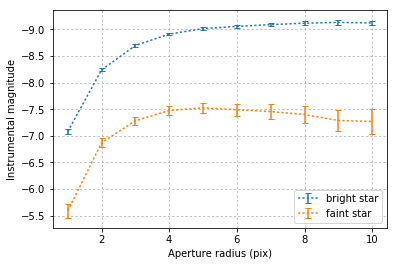

In [21]:
from photutils import aperture_photometry as apphot
from photutils import CircularAperture

# Although you can generate the pixel-wise error map via ccdproc,
# you should somehow change the ADU unit to 'electrons' eventually.
errormap = np.sqrt(image * gain + ronoise**2)/gain # in ADU unit


# Set some values (position, aperture radii, ...)
pos   = [pos1, pos2]
rmax  = 10
nstar = 2
rapert = np.arange(1, rmax+1)
flux  = np.zeros((len(rapert), nstar))
ferr  = np.zeros((len(rapert), nstar))

for i in range(len(rapert)):
    apertures = CircularAperture(pos, r=rapert[i])
    photometry = apphot(image,                # input image or data
                        apertures,            # the ~photutils.aperture object
                        error=errormap,       # pixelwise error values
                        pixelwise_error=True, # whether to apply errors pixelwise
                        method='exact')       # aperture sum/error calculating method
    flux[i,:] = photometry['aperture_sum'].data - m_s * apertures.area() # in ADU
    # Nothing but "aperture sum - sky * area"
    ferr[i,:] = np.sqrt(photometry['aperture_sum_err'].data**2 
                        + apertures.area() * s_s**2 / n_s) # in ADU
    # The first term contains the poisson and readout noise terms.
    # So I added only the "n_a^2 * s_s^2 / n_s" term.
    
magn = -2.5 * np.log10(flux * gain) # multiply gain to make it realistic unit
merr = 1.0857 * (ferr/flux)         # gain in denom/numer cancels out

plt.errorbar(rapert, magn[:,0], yerr=merr[:,0], ls=':',
             capsize=3, label='bright star')
plt.errorbar(rapert, magn[:,1], yerr=merr[:,1], ls=':', 
             capsize=3, label='faint star')
plt.gca().invert_yaxis()
plt.grid(ls=':')
plt.xlabel('Aperture radius (pix)')
plt.ylabel('Instrumental magnitude')
plt.legend()
plt.show()


* **Question**: Which apertures are good choices for the stars?
* **TIP**: The selection of optimum radii is done by the *growth curve*: the curve I drew (more rigorously, the change in magnitude (and its error) with respect to aperture radius). Of course there is no single way to select one best aperture radius, and one of the most widely used algorithm is the DAOGROWTH algorithm suggested by P. B. Stetson (Stetson (1990), PASP, **102**, *932*).

* **Question**: Delete or add each term of the `ferr`. Which factor is dominant? Which factor is negligible? Is that what you expected?